In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/oneship.csv')

# 필요 없는 열 제거
data = data.drop(columns=['id', 'msg_type', 'mmsi', 'status', 'created_at', 'datetime'])

# 타겟 변수와 독립 변수
target_columns = ['lat', 'lon']  # 타겟 변수
independent_columns = list(data.columns)  # 모든 열을 독립변수로 포함

# 시계열 데이터 변환
time_steps = 50
X, y = [], []
for i in range(len(data) - time_steps):
    # 입력 데이터: 모든 독립변수 포함
    X.append(data.iloc[i:i+time_steps][independent_columns].values)
    # 출력 데이터: 타겟 변수만 포함
    y.append(data.iloc[i+time_steps][target_columns].values)
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (1097, 50, 30), y 크기: (1097, 2)


In [2]:
# 데이터 분할
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터 크기: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (767, 50, 30), (767, 2)
Validation 데이터 크기: (164, 50, 30), (164, 2)
Test 데이터 크기: (166, 50, 30), (166, 2)


In [3]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [4]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 6599.2541
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 7507.2809
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 2921.8909
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 8007.6020
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 9796.0320
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 7859.4775
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 9023.2126
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 8257.6911
Params: {'num_layers': 1, 'learning_ra

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 128}, Loss: 10773.3598
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 9022.4699
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 7462.3548
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 3632.5991
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 9840.9049
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 7872.3919


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 16}, Loss: 8239.2900
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 128}, Loss: 10743.1105
Params: {'num_layers': 4, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.2, 'batch_size': 32}, Loss: 8036.9522
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 32}, Loss: 9352.9297
최적 파라미터: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, 손실: 2921.8909


In [5]:
# 최적 파라미터
best_params = {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}

best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])



In [6]:
# 학습 루프
num_epochs = 100
train_loss_list = []

best_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    train_loss_list.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/100], Loss: 38.1903
Epoch [2/100], Loss: 1.1966
Epoch [3/100], Loss: 0.0290
Epoch [4/100], Loss: 0.0080
Epoch [5/100], Loss: 0.0067
Epoch [6/100], Loss: 0.0066
Epoch [7/100], Loss: 0.0071
Epoch [8/100], Loss: 0.0090
Epoch [9/100], Loss: 0.0106
Epoch [10/100], Loss: 0.0109
Epoch [11/100], Loss: 0.0102
Epoch [12/100], Loss: 0.0102
Epoch [13/100], Loss: 0.0115
Epoch [14/100], Loss: 0.0132
Epoch [15/100], Loss: 0.0145
Epoch [16/100], Loss: 0.0149
Epoch [17/100], Loss: 0.0148
Epoch [18/100], Loss: 0.0146
Epoch [19/100], Loss: 0.0143
Epoch [20/100], Loss: 0.0140
Epoch [21/100], Loss: 0.0134
Epoch [22/100], Loss: 0.0125
Epoch [23/100], Loss: 0.0115
Epoch [24/100], Loss: 0.0106
Epoch [25/100], Loss: 0.0098
Epoch [26/100], Loss: 0.0092
Epoch [27/100], Loss: 0.0089
Epoch [28/100], Loss: 0.0086
Epoch [29/100], Loss: 0.0086
Epoch [30/100], Loss: 0.0088
Epoch [31/100], Loss: 0.0092
Epoch [32/100], Loss: 0.0097
Epoch [33/100], Loss: 0.0101
Epoch [34/100], Loss: 0.0103
Epoch [35/100], Loss: 

In [7]:
# 테스트 데이터 평가
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    y_pred = best_model(X_test_tensor).detach().cpu().numpy()  # 예측 값
    y_true = y_test  # 실제 값

    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']]
        y_batch = y_test_tensor[i:i+best_params['batch_size']]
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0159


In [8]:
# 예측 값과 실제 값 비교
comparison = pd.DataFrame({
    'True Lat': y_true[:, 0],
    'True Lon': y_true[:, 1],
    'Predicted Lat': y_pred[:, 0],
    'Predicted Lon': y_pred[:, 1]
})
print(comparison.head())

    True Lat    True Lon  Predicted Lat  Predicted Lon
0  34.934155  129.392593      34.932682     129.411758
1  34.933231  129.391846      34.932682     129.411758
2  34.932716  129.391434      34.932682     129.411758
3  34.931812  129.390717      34.932682     129.411758
4  34.931335  129.390335      34.932682     129.411758


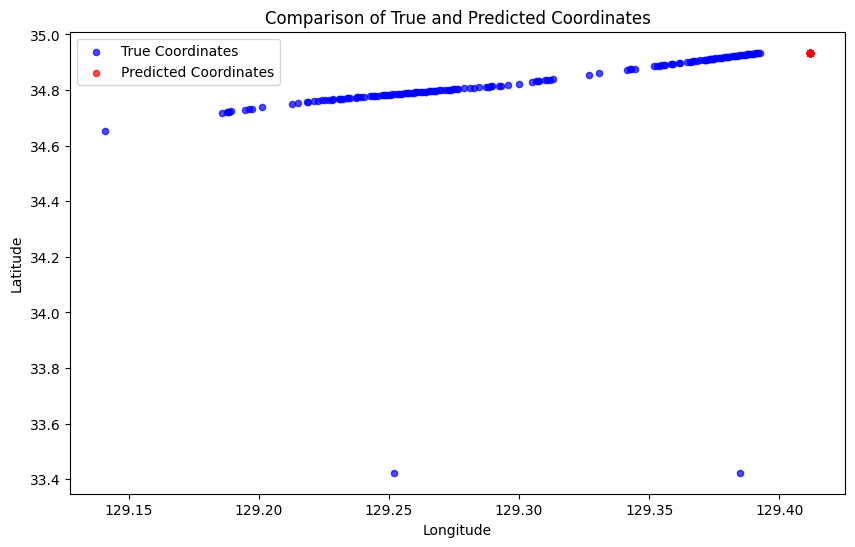

In [9]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 산포도
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:, 1], y_true[:, 0], label='True Coordinates', alpha=0.7, c='blue', s=20)  # 실제 좌표
plt.scatter(y_pred[:, 1], y_pred[:, 0], label='Predicted Coordinates', alpha=0.7, c='red', s=20)  # 예측 좌표
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Comparison of True and Predicted Coordinates')
plt.legend()
plt.show()


               lat          lon
count  1147.000000  1147.000000
mean     35.025621   129.404092
std       0.156378     0.066075
min      33.423360   129.140953
25%      34.944502   129.398560
50%      35.036947   129.412977
75%      35.131514   129.449335
max      35.380102   129.744252


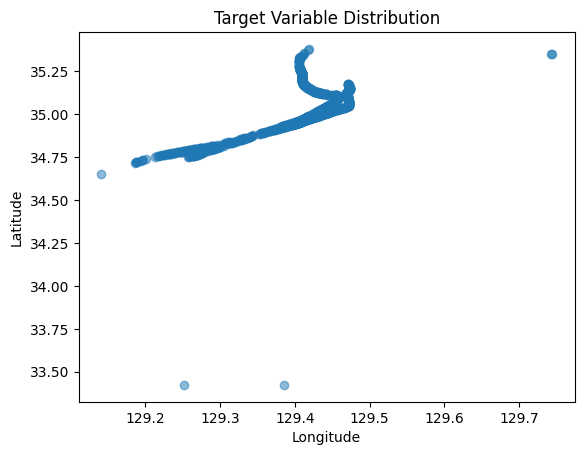

In [10]:
# 타겟 변수의 분포 확인
print(data[['lat', 'lon']].describe())

# 타겟 변수의 시각화
import matplotlib.pyplot as plt
plt.scatter(data['lon'], data['lat'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Target Variable Distribution')
plt.show()


In [11]:
# 입력 데이터 샘플 확인
print("독립변수 데이터 요약:")
print(pd.DataFrame(X.reshape(-1, X.shape[-1])).describe())



독립변수 데이터 요약:
                 0             1        2             3             4   \
count  54850.000000  54850.000000  54850.0  54850.000000  54850.000000   
mean       0.042545      0.081327      0.0    129.408401     35.025780   
std        0.256678      0.018649      0.0      0.060786      0.147261   
min       -0.984375      0.006299      0.0    129.185638     33.423359   
25%        0.007812      0.070866      0.0    129.401230     34.947296   
50%        0.007812      0.074803      0.0    129.415237     35.037176   
75%        0.007812      0.096063      0.0    129.450760     35.128143   
max        2.468750      0.109449      0.0    129.744247     35.380100   

                 5             6             7             8             9   \
count  54850.000000  54850.000000  54850.000000  54850.000000  54850.000000   
mean       0.537772      0.381854      0.200282      0.462165      0.285761   
std        0.061321      0.041679      0.326197      0.394841      0.219505   
min 

In [12]:

# 타겟 변수의 분포 확인
print("타겟 변수 분포:")
print(pd.DataFrame(y, columns=['lat', 'lon']).describe())

타겟 변수 분포:
               lat          lon
count  1097.000000  1097.000000
mean     35.013580   129.403946
std       0.148922     0.067558
min      33.423359   129.140945
25%      34.940861   129.395218
50%      35.029049   129.415237
75%      35.120399   129.450760
max      35.349743   129.744247
